<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/11-Data%20Preprocessing/Data_Preparation_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Business Problem:

To predict the number of bikes taken and returned at each station for shared bike service provider


In [1]:
### Necessary imports
import os
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz

In [2]:
station_data='https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/station_data.csv'
trip_data='https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/trip_data.csv'
weather_data='https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/weather_data.csv'

### Reading all files

df_station = pd.read_csv(station_data)
df_trip = pd.read_csv(trip_data)
df_weather = pd.read_csv(weather_data)

In [3]:
df_station.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [4]:
df_station.shape

(76, 6)

In [5]:
### to merge with the externally sourced zip to latlong mapping
df_station['Lat'] = np.round(df_station['Lat'], 1)
df_station['Long'] = np.round(df_station['Long'], 1)

In [7]:
### we have a total of 71 stations 
df_station.nunique()

Id            76
Name          71
Lat            4
Long           4
Dock Count     6
City           5
dtype: int64

In [8]:
### 5 cities
df_station.City.unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

Trip data analysis

In [9]:
df_trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [10]:
### Only 2 subsriber types, Lets bring the necessary information from df_trip to arrive at the variable of interest
df_trip.nunique()

Trip ID            354152
Start Date         181944
Start Station          76
End Date           180406
End Station            76
Subscriber Type         2
dtype: int64

What is the target variable? Net rate: (trips ended - trips started) at the station for a given hour

In [11]:
df_trip['Start hour'] = df_trip['Start Date'].apply(lambda x: str(x).split(":")[0])
df_trip['End hour'] = df_trip['End Date'].apply(lambda x: str(x).split(":")[0])

In [12]:
df_start_count = df_trip.groupby(['Start hour', 'Start Station']).count().reset_index()[['Start hour', 'Start Station', 'Trip ID']]
df_end_count = df_trip.groupby(['End hour', 'End Station']).count().reset_index()[['End hour', 'End Station', 'Trip ID']]

In [13]:
df_end_count.columns = ['hour', 'station', 'trip']
df_start_count.columns = ['hour', 'station', 'trip']

In [14]:
df_delta = pd.merge(df_end_count, df_start_count, on = ['hour', 'station'])
df_delta['net_rate'] = df_delta['trip_x'] - df_delta['trip_y'] 

### Deriving date column to merge trip info with weather
df_delta['hour'] = pd.to_datetime(df_delta['hour'])
df_delta['date']  = (df_delta['hour']).apply(lambda x: x.date())

### Merging the net_rate i.e. VoI with the station data
df_station_netrate = df_delta.merge(df_station, left_on = 'station', right_on = 'Id', how = 'left')

In [15]:
df_station_netrate.head()

,hour,station,trip_x,trip_y,net_rate,date,Id,Name,Lat,Long,Dock Count,City
0,2015-01-01 01:00:00,66,4,1,3,2015-01-01,66,South Van Ness at Market,37.8,-122.4,19,San Francisco
1,2015-01-01 11:00:00,50,3,1,2,2015-01-01,50,Harry Bridges Plaza (Ferry Building),37.8,-122.4,23,San Francisco
2,2015-01-01 11:00:00,68,2,2,0,2015-01-01,68,Yerba Buena Center of the Arts (3rd @ Howard),37.8,-122.4,19,San Francisco
3,2015-01-01 11:00:00,76,2,4,-2,2015-01-01,76,Market at 4th,37.8,-122.4,19,San Francisco
4,2015-01-01 12:00:00,39,2,2,0,2015-01-01,39,Powell Street BART,37.8,-122.4,19,San Francisco


Weather data analysis

In [16]:
df_weather.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,29.87,29.82,29.79,10.0,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,29.81,29.76,29.72,10.0,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,29.81,29.76,29.72,10.0,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,29.92,29.87,29.81,10.0,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [17]:
### Check columns: we have statistical features i.e. min, max and min of key weather attributes like: Temp, pressure, humidity etc
df_weather.columns

Index(['Date', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       'Mean Humidity', 'Min Humidity', 'Max Sea Level PressureIn',
       'Mean Sea Level PressureIn', 'Min Sea Level PressureIn',
       'Max VisibilityMiles', 'Mean VisibilityMiles', 'Min VisibilityMiles',
       'Max Wind SpeedMPH', 'Mean Wind SpeedMPH', 'Max Gust SpeedMPH',
       'PrecipitationIn', 'CloudCover', 'Events', 'WindDirDegrees', 'Zip'],
      dtype='object')

In [18]:
### Lets check summary stats for weather features
df_weather.describe()

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Zip
count,1821.000000,1821.000000,1821.000000,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000,1824.000000,1824.000000,1824.000000,1820.000000,1820.000000,1820.000000,1824.000000,1824.000000,1284.000000,1824.000000,1824.000000,1824.000000,1825.000000
mean,70.637013,61.837452,52.733663,54.460845,50.397183,46.135775,87.505915,69.282817,48.769014,30.070641,30.017144,29.962659,10.475275,9.636813,7.948901,16.347588,6.150219,21.690810,0.025032,3.110746,260.584430,94325.000000
std,8.260028,6.893216,7.037803,6.330125,7.101097,8.548960,8.537459,10.408295,14.274316,0.135416,0.131222,0.132534,2.083719,1.433697,2.993878,8.592296,3.238621,6.052399,0.177212,2.297131,95.985517,404.670892
min,50.000000,41.000000,30.000000,20.000000,13.000000,4.000000,25.000000,25.000000,4.000000,29.670000,29.630000,29.340000,5.000000,4.000000,0.000000,4.000000,0.000000,7.000000,0.000000,0.000000,0.000000,94041.000000
25%,64.000000,57.000000,48.000000,50.000000,47.000000,41.000000,83.000000,64.000000,40.000000,29.970000,29.920000,29.870000,10.000000,10.000000,6.000000,12.000000,4.000000,18.000000,0.000000,1.000000,242.000000,94063.000000
50%,70.000000,61.000000,53.000000,55.000000,51.000000,48.000000,88.000000,70.000000,50.000000,30.050000,30.000000,29.950000,10.000000,10.000000,10.000000,16.000000,6.000000,22.000000,0.000000,3.000000,295.000000,94107.000000
75%,76.000000,67.000000,58.000000,59.000000,56.000000,53.000000,93.000000,75.000000,57.000000,30.170000,30.110000,30.050000,10.000000,10.000000,10.000000,20.000000,8.000000,25.000000,0.000000,5.000000,328.000000,94301.000000
max,102.000000,82.000000,75.000000,68.000000,64.000000,63.000000,100.000000,96.000000,86.000000,30.480000,30.410000,30.360000,20.000000,20.000000,20.000000,128.000000,23.000000,62.000000,3.360000,8.000000,360.000000,95113.000000


In [19]:
df_weather.shape

(1825, 24)

In [20]:
### Total NaNs in 'Events' are very high, will drop in further analysis
df_weather.isnull().sum()

Date                            0
Max TemperatureF                4
Mean TemperatureF               4
Min TemperatureF                4
Max Dew PointF                 50
MeanDew PointF                 50
Min DewpointF                  50
Max Humidity                   50
Mean Humidity                  50
Min Humidity                   50
Max Sea Level PressureIn        1
Mean Sea Level PressureIn       1
Min Sea Level PressureIn        1
Max VisibilityMiles             5
Mean VisibilityMiles            5
Min VisibilityMiles             5
Max Wind SpeedMPH               1
Mean Wind SpeedMPH              1
Max Gust SpeedMPH             541
PrecipitationIn                 1
CloudCover                      1
Events                       1538
WindDirDegrees                  1
Zip                             0
dtype: int64

In [21]:
### Lets check more on this feature: Events
df_weather['Events'].unique()

array([nan, 'Rain', 'Fog', 'Fog-Rain', 'Rain-Thunderstorm'], dtype=object)

In [22]:
### only a few events captured under Rain, Fog and Fog-Rain have weather details
df_weather['Events'].value_counts()

Rain                 195
Fog                   73
Fog-Rain              16
Rain-Thunderstorm      3
Name: Events, dtype: int64

Need lat long to zipcode mapping data to merge the df_weather with df_station

In [23]:
zll_data='https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/us-zip-code-latitude-and-longitude.csv'
zip_to_latlong = pd.read_csv(zll_data, sep=';')

In [24]:
### For all relevant cities prsent in out df_station data, get lat long information with corresponding zip 
zip_to_latlong = zip_to_latlong[zip_to_latlong.City.isin(df_station.City.unique())]

### Filter the columns
zip_to_latlong = zip_to_latlong[['Zip', 'Latitude', 'Longitude']]

### Prepared zip and latlong data
zip_to_latlong

,Zip,Latitude,Longitude
88,94156,37.784827,-122.727802
523,95159,37.189396,-121.705327
774,94303,37.449888,-122.127490
1427,94142,37.784827,-122.727802
1706,94122,37.758380,-122.484780
...,...,...,...
42062,94170,37.784827,-122.727802
42164,95135,37.299474,-121.754460
42429,94171,37.784827,-122.727802
42608,94147,37.784827,-122.727802


In [25]:
zip_to_latlong.head()

,Zip,Latitude,Longitude
88,94156,37.784827,-122.727802
523,95159,37.189396,-121.705327
774,94303,37.449888,-122.127490
1427,94142,37.784827,-122.727802
1706,94122,37.758380,-122.484780


In [26]:
### MErging the weather data with externally sourced lat long to join with station and trip data at date level
df_weather_latlong = df_weather.merge(zip_to_latlong, on = 'Zip', how = 'left')

In [27]:
### necessary round off for merging
df_weather_latlong['Latitude'] = np.round(df_weather_latlong['Latitude'], 1)
df_weather_latlong['Longitude'] = np.round(df_weather_latlong['Longitude'], 1)

In [28]:
df_weather_latlong.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,Latitude,Longitude
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107,37.8,-122.4
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,29.87,29.82,29.79,10.0,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107,37.8,-122.4
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,29.81,29.76,29.72,10.0,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107,37.8,-122.4
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,29.81,29.76,29.72,10.0,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107,37.8,-122.4
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,29.92,29.87,29.81,10.0,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107,37.8,-122.4


In [29]:
df_weather_latlong.dtypes

Date                          object
Max TemperatureF             float64
Mean TemperatureF            float64
Min TemperatureF             float64
Max Dew PointF               float64
MeanDew PointF               float64
Min DewpointF                float64
Max Humidity                 float64
Mean Humidity                float64
Min Humidity                 float64
Max Sea Level PressureIn     float64
Mean Sea Level PressureIn    float64
Min Sea Level PressureIn     float64
Max VisibilityMiles          float64
Mean VisibilityMiles         float64
Min VisibilityMiles          float64
Max Wind SpeedMPH            float64
Mean Wind SpeedMPH           float64
Max Gust SpeedMPH            float64
PrecipitationIn              float64
CloudCover                   float64
Events                        object
WindDirDegrees               float64
Zip                            int64
Latitude                     float64
Longitude                    float64
dtype: object

In [30]:
df_station.shape

(76, 6)

Date type correction for appropriate merge

In [31]:
df_weather_latlong['Date']  = pd.to_datetime(df_weather_latlong['Date'])
df_station_netrate['date'] = pd.to_datetime(df_station_netrate['date'])

Merging df_weather_latlong with station data

In [32]:
df_station_weather = pd.merge(df_station_netrate, df_weather_latlong, left_on = ['Lat', 'Long', 'date'], right_on = ['Latitude', 
                                                                        'Longitude', 'Date'])


In [33]:
df_station_weather['hour_of_day'] = df_station_weather['hour'].apply(lambda x: int(str(x).split(' ')[-1].split(':')[0]))

In [34]:
df_station_weather

,hour,station,trip_x,trip_y,net_rate,date,Id,Name,Lat,Long,Dock Count,City,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,Latitude,Longitude,hour_of_day
0,2015-01-01 01:00:00,66,4,1,3,2015-01-01,66,South Van Ness at Market,37.8,-122.4,19,San Francisco,2015-01-01,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,NaN,40.0,94107,37.8,-122.4,1
1,2015-01-01 11:00:00,50,3,1,2,2015-01-01,50,Harry Bridges Plaza (Ferry Building),37.8,-122.4,23,San Francisco,2015-01-01,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,NaN,40.0,94107,37.8,-122.4,11
2,2015-01-01 11:00:00,68,2,2,0,2015-01-01,68,Yerba Buena Center of the Arts (3rd @ Howard),37.8,-122.4,19,San Francisco,2015-01-01,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,NaN,40.0,94107,37.8,-122.4,11
3,2015-01-01 11:00:00,76,2,4,-2,2015-01-01,76,Market at 4th,37.8,-122.4,19,San Francisco,2015-01-01,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,NaN,40.0,94107,37.8,-122.4,11
4,2015-01-01 12:00:00,39,2,2,0,2015-01-01,39,Powell Street BART,37.8,-122.4,19,San Francisco,2015-01-01,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,NaN,40.0,94107,37.8,-122.4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82974,2014-12-31 18:00:00,67,1,2,-1,2014-12-31,67,Market at 10th,37.8,-122.4,27,San Francisco,2014-12-31,59.0,48.0,36.0,36.0,17.0,5.0,67.0,41.0,15.0,30.27,30.17,30.07,10.0,10.0,10.0,21.0,7.0,28.0,0.0,1.0,NaN,8.0,94107,37.8,-122.4,18
82975,2014-12-31 18:00:00,70,1,1,0,2014-12-31,70,San Francisco Caltrain (Townsend at 4th),37.8,-122.4,19,San Francisco,2014-12-31,59.0,48.0,36.0,36.0,17.0,5.0,67.0,41.0,15.0,30.27,30.17,30.07,10.0,10.0,10.0,21.0,7.0,28.0,0.0,1.0,NaN,8.0,94107,37.8,-122.4,18
82976,2014-12-31 18:00:00,82,1,1,0,2014-12-31,82,Broadway St at Battery St,37.8,-122.4,15,San Francisco,2014-12-31,59.0,48.0,36.0,36.0,17.0,5.0,67.0,41.0,15.0,30.27,30.17,30.07,10.0,10.0,10.0,21.0,7.0,28.0,0.0,1.0,NaN,8.0,94107,37.8,-122.4,18
82977,2014-12-31 19:00:00,60,2,2,0,2014-12-31,60,Embarcadero at Sansome,37.8,-122.4,15,San Francisco,2014-12-31,59.0,48.0,36.0,36.0,17.0,5.0,67.0,41.0,15.0,30.27,30.17,30.07,10.0,10.0,10.0,21.0,7.0,28.0,0.0,1.0,NaN,8.0,94107,37.8,-122.4,19


In [35]:
### Date type features: Feature Engg
### to capture Week day vs weekend usage variation
df_station_weather['week_of_year'] = df_station_weather['Date'].dt.week
df_station_weather['day_of_month'] = df_station_weather['Date'].apply(lambda x: str(x).split('-')[-1].split(' ')[0])
df_station_weather['month_of_year'] = df_station_weather['Date'].dt.month
df_station_weather['day_of_week'] = df_station_weather['Date'].dt.dayofweek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
cols_to_remove = ['hour', 'trip_x', 'trip_y', 'date', 'Lat', 'Long', 'station', 'Zip', 'Id', 'Name', 'City', 'Date', 'Events']

df_final = df_station_weather.drop(columns=cols_to_remove)

In [37]:
df_final.head()

,net_rate,Dock Count,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Latitude,Longitude,hour_of_day,week_of_year,day_of_month,month_of_year,day_of_week
0,3,19,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,40.0,37.8,-122.4,1,1,01,1,3
1,2,23,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,40.0,37.8,-122.4,11,1,01,1,3
2,0,19,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,40.0,37.8,-122.4,11,1,01,1,3
3,-2,19,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,40.0,37.8,-122.4,11,1,01,1,3
4,0,19,56.0,47.0,38.0,27.0,20.0,14.0,54.0,37.0,20.0,30.18,30.13,30.07,10.0,10.0,10.0,23.0,8.0,28.0,0.0,1.0,40.0,37.8,-122.4,12,1,01,1,3


In [38]:
df_corr = df_final.corr()
df_corr

,net_rate,Dock Count,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Latitude,Longitude,hour_of_day,week_of_year,month_of_year,day_of_week
net_rate,1.000000,-0.002124,0.001432,-0.000180,-0.001667,0.002298,0.001294,0.000384,0.001249,-0.000173,-0.000794,0.002192,0.001952,0.001686,-0.000940,-0.001797,-0.002589,-0.004732,-0.006002,-0.003070,-0.002176,-0.001754,-0.001063,0.007006,-0.006575,0.061147,0.002870,0.002735,-0.003234
Dock Count,-0.002124,1.000000,-0.001670,0.000346,0.002583,0.001119,0.003012,0.003973,-0.001883,0.004656,0.006288,-0.004515,-0.006034,-0.006424,-0.018287,-0.004759,-0.002784,0.002489,0.005611,0.008619,0.009104,0.007044,-0.005533,0.035928,-0.030639,-0.020969,0.010631,0.011042,-0.011463
Max TemperatureF,0.001432,-0.001670,1.000000,0.893801,0.557964,0.646272,0.515157,0.394650,-0.175050,-0.459311,-0.513728,-0.427068,-0.397840,-0.373629,0.080484,0.278280,0.264533,0.096253,0.013346,0.129158,-0.169439,-0.379574,0.364062,-0.150596,0.149113,0.001533,0.144951,0.104562,-0.012428
Mean TemperatureF,-0.000180,0.000346,0.893801,1.000000,0.869253,0.783468,0.743764,0.672357,-0.201315,-0.247680,-0.219085,-0.604843,-0.570139,-0.535182,0.094922,0.263775,0.213726,0.284019,0.288813,0.267540,-0.080645,-0.051449,0.322053,-0.113867,0.110159,0.000053,0.233703,0.185542,0.006504
Min TemperatureF,-0.001667,0.002583,0.557964,0.869253,1.000000,0.745529,0.817013,0.816957,-0.178846,0.050819,0.163730,-0.651669,-0.618948,-0.579888,0.092565,0.184741,0.103285,0.415211,0.513728,0.349399,0.032650,0.326834,0.201242,-0.045207,0.039357,-0.001457,0.277386,0.231028,0.025352
Max Dew PointF,0.002298,0.001119,0.646272,0.783468,0.745529,1.000000,0.930410,0.813220,0.258050,0.256252,0.196570,-0.449769,-0.418938,-0.384020,0.061709,-0.017136,-0.083954,0.097984,0.086622,0.118561,0.057768,0.122636,0.234462,-0.042162,0.032158,0.002657,0.340919,0.286242,0.032853
MeanDew PointF,0.001294,0.003012,0.515157,0.743764,0.817013,0.930410,1.000000,0.954161,0.267566,0.405181,0.389319,-0.536564,-0.500895,-0.460579,0.053891,-0.031111,-0.110695,0.161075,0.201765,0.129738,0.058213,0.287002,0.198537,0.001023,-0.008378,0.000729,0.334660,0.266215,0.056123
Min DewpointF,0.000384,0.003973,0.394650,0.672357,0.816957,0.813220,0.954161,1.000000,0.201940,0.454781,0.490539,-0.566247,-0.527482,-0.484652,0.047561,0.007000,-0.086260,0.201006,0.289291,0.131092,0.052055,0.376358,0.146959,0.025494,-0.031104,-0.000909,0.299323,0.234799,0.060859
Max Humidity,0.001249,-0.001883,-0.175050,-0.201315,-0.178846,0.258050,0.267566,0.201940,1.000000,0.722492,0.411359,0.101286,0.095914,0.088353,-0.075334,-0.468700,-0.481666,-0.197562,-0.313569,-0.174789,0.148507,0.097524,-0.048722,0.069851,-0.069095,0.006099,0.047410,0.037001,0.083016
Mean Humidity,-0.000173,0.004656,-0.459311,-0.247680,0.050819,0.256252,0.405181,0.454781,0.722492,1.000000,0.924313,-0.011268,-0.010272,-0.002499,-0.079185,-0.486169,-0.528732,-0.086456,-0.046267,-0.123293,0.233070,0.516284,-0.171701,0.149401,-0.151432,0.001785,0.126328,0.105129,0.070953


In [39]:
df_final.columns

Index(['net_rate', 'Dock Count', 'Max TemperatureF', 'Mean TemperatureF',
       'Min TemperatureF', 'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF',
       'Max Humidity', 'Mean Humidity', 'Min Humidity',
       'Max Sea Level PressureIn', 'Mean Sea Level PressureIn',
       'Min Sea Level PressureIn', 'Max VisibilityMiles',
       'Mean VisibilityMiles', 'Min VisibilityMiles', 'Max Wind SpeedMPH',
       'Mean Wind SpeedMPH', 'Max Gust SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'WindDirDegrees', 'Latitude', 'Longitude', 'hour_of_day',
       'week_of_year', 'day_of_month', 'month_of_year', 'day_of_week'],
      dtype='object')

In [40]:
### Min and Max attributes have been removed due to high correlation with 'Mean' attribute
df_final = df_final[[k for k in df_final.columns if ('Max' not in k) and ('Min' not in k)]]

Exploratory data analysis

Net rate is highly impacted by extreme temp


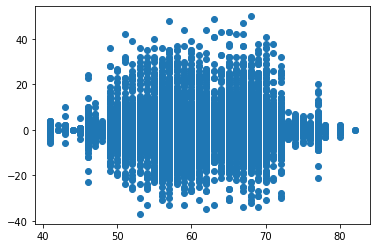

In [41]:
plt.scatter(x = df_final['Mean TemperatureF'], y = df_final['net_rate'])

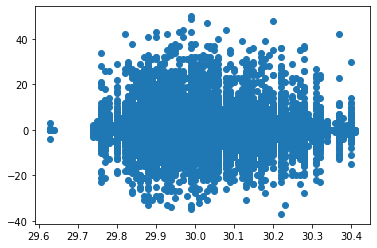

In [42]:
plt.scatter(x = df_final['Mean Sea Level PressureIn'], y = df_final['net_rate'])

Lower net rate at higher wind speeds, which goes well with intuitive explanation

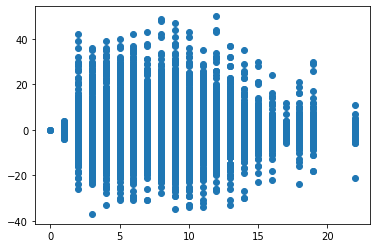

In [43]:
plt.scatter(x = df_final['Mean Wind SpeedMPH'], y = df_final['net_rate'])

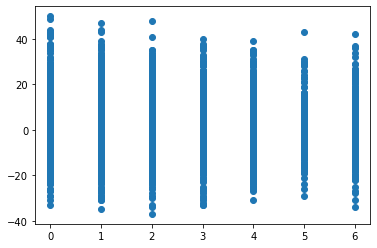

In [44]:
plt.scatter(df_final['day_of_week'], df_final['net_rate'])

We observe net rate to be lower around night time from midnight to 5 AM

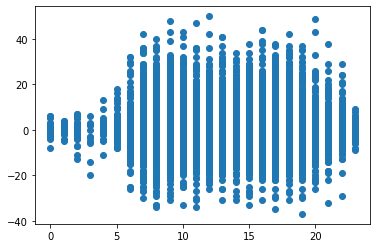

In [45]:
plt.scatter(np.sort(df_final['hour_of_day']), df_final['net_rate'])

Net rate distribution

(array([1.0000e+00, 3.0000e+00, 5.0000e+00, 6.0000e+00, 1.1000e+01,
        1.1000e+01, 1.7000e+01, 7.0000e+00, 2.8000e+01, 5.3000e+01,
        8.0000e+01, 4.2000e+01, 1.0300e+02, 1.6100e+02, 2.3200e+02,
        1.8000e+02, 6.6800e+02, 1.4920e+03, 3.8600e+03, 3.7460e+03,
        1.8786e+04, 3.6068e+04, 1.0271e+04, 2.1470e+03, 2.3130e+03,
        1.0790e+03, 2.7100e+02, 3.6800e+02, 2.2000e+02, 1.6000e+02,
        7.0000e+01, 8.6000e+01, 7.0000e+01, 7.3000e+01, 4.9000e+01,
        6.4000e+01, 4.6000e+01, 4.0000e+01, 1.4000e+01, 2.6000e+01,
        1.0000e+01, 1.4000e+01, 6.0000e+00, 6.0000e+00, 4.0000e+00,
        6.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-37.  , -35.26, -33.52, -31.78, -30.04, -28.3 , -26.56, -24.82,
        -23.08, -21.34, -19.6 , -17.86, -16.12, -14.38, -12.64, -10.9 ,
         -9.16,  -7.42,  -5.68,  -3.94,  -2.2 ,  -0.46,   1.28,   3.02,
          4.76,   6.5 ,   8.24,   9.98,  11.72,  13.46,  15.2 ,  16.94,
         18.68,  20.42,  22.16

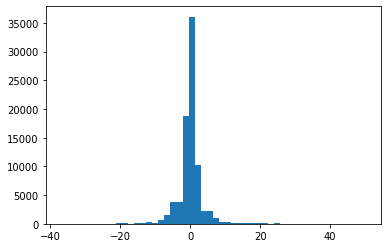

In [46]:
plt.hist(df_final['net_rate'], bins = 50)

Modelling

In [47]:
### Train and test split with 30% test size
df_final['day_of_month'] = df_final['day_of_month'].apply(lambda x: int(x))
y = df_final['net_rate']
X = df_final.drop(columns='net_rate')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)


In [48]:
X_train.head()

,Dock Count,Mean TemperatureF,MeanDew PointF,Mean Humidity,Mean Sea Level PressureIn,Mean VisibilityMiles,Mean Wind SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Latitude,Longitude,hour_of_day,week_of_year,day_of_month,month_of_year,day_of_week
75479,23,72.0,55.0,62.0,29.87,10.0,6.0,0.0,0.0,291.0,37.8,-122.4,10,31,28,7,1
73990,19,57.0,48.0,69.0,30.05,10.0,4.0,0.0,2.0,300.0,37.8,-122.4,17,44,27,10,0
42246,15,65.0,36.0,47.0,30.02,10.0,8.0,0.0,0.0,329.0,37.8,-122.4,13,16,16,4,3
74429,19,53.0,46.0,73.0,30.22,10.0,3.0,0.0,2.0,265.0,37.8,-122.4,19,5,28,1,2
57098,19,66.0,56.0,70.0,29.88,10.0,11.0,0.0,6.0,262.0,37.8,-122.4,16,34,21,8,4


In [49]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Dock Count,58085.0,19.557321,4.121457,11.00,15.00,19.00,23.00,27.00
Mean TemperatureF,58077.0,61.091947,6.039059,41.00,57.00,60.00,66.00,82.00
MeanDew PointF,58046.0,50.409796,6.062237,13.00,47.00,51.00,55.00,63.00
Mean Humidity,58046.0,70.392172,8.707469,29.00,66.00,71.00,75.00,95.00
Mean Sea Level PressureIn,58082.0,30.012310,0.127399,29.63,29.91,29.99,30.09,30.41
Mean VisibilityMiles,58081.0,9.455553,1.163565,4.00,9.00,10.00,10.00,19.00
Mean Wind SpeedMPH,58082.0,7.624100,3.356100,0.00,5.00,8.00,10.00,22.00
PrecipitationIn,58082.0,0.023468,0.134251,0.00,0.00,0.00,0.00,3.23
CloudCover,58082.0,3.951345,2.259863,0.00,2.00,4.00,6.00,8.00
WindDirDegrees,58082.0,258.216969,66.902045,0.00,250.00,273.00,297.00,360.00


In [50]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [51]:
### Fitting linear reg
reg_obj = LinearRegression().fit(X_train, y_train)
y_train_pred = reg_obj.predict(X_train)
y_test_pred = reg_obj.predict(X_test)

In [52]:
np.sqrt(mean_squared_error(y_train, y_train_pred))

3.765563611537702

In [53]:
np.sqrt(mean_squared_error(y_test, y_test_pred))

3.824252526843629

DecisionTreeRegressor

To visualize the factors determing the net rate


In [54]:
reg_DT = DecisionTreeRegressor(random_state=4).fit(X_train, y_train)

y_train_pred_DT = reg_DT.predict(X_train)
y_test_pred_DT = reg_DT.predict(X_test)

np.sqrt(mean_squared_error(y_train, y_train_pred_DT)), np.sqrt(mean_squared_error(y_test, y_test_pred_DT))


(3.039673262915482, 4.1029224084149165)

In [55]:
### pruning the decision tree by setting max_depth = 3
reg_DT = DecisionTreeRegressor(max_depth = 3, random_state=4).fit(X_train, y_train)

y_train_pred_DT = reg_DT.predict(X_train)
y_test_pred_DT = reg_DT.predict(X_test)

np.sqrt(mean_squared_error(y_train, y_train_pred_DT)), np.sqrt(mean_squared_error(y_test, y_test_pred_DT))

(3.628563724180922, 3.6834277151482726)